skfuzzy 0.4.2
====
A fuzzy logic toolbox for SciPy.

## Fuzzy c-means clustering 
Fuzzy logic principles can be used to cluster multidimensional data, assigning each point a membership in each cluster center from 0 to 100 percent. This can be very powerful compared to traditional hard-thresholded clustering where every point is assigned a crisp, exact label.

Fuzzy c-means clustering is accomplished via `skfuzzy.cmeans`, and the output from this function can be repurposed to classify new data according to the calculated clusters (also known as prediction) via `skfuzzy.cmeans_predict`.

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

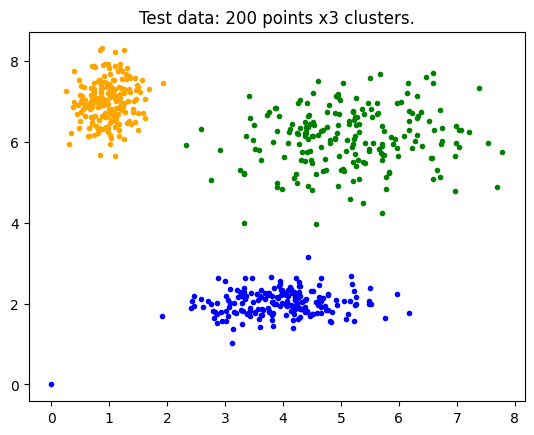

In [1]:
# data generation and setup
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# generate test data
np.random.seed(42)
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    # xpts = np.hstack((xpts, np.random.randn(200) * xsigma + xmu))
    # ypts = np.hstack((ypts, np.random.randn(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

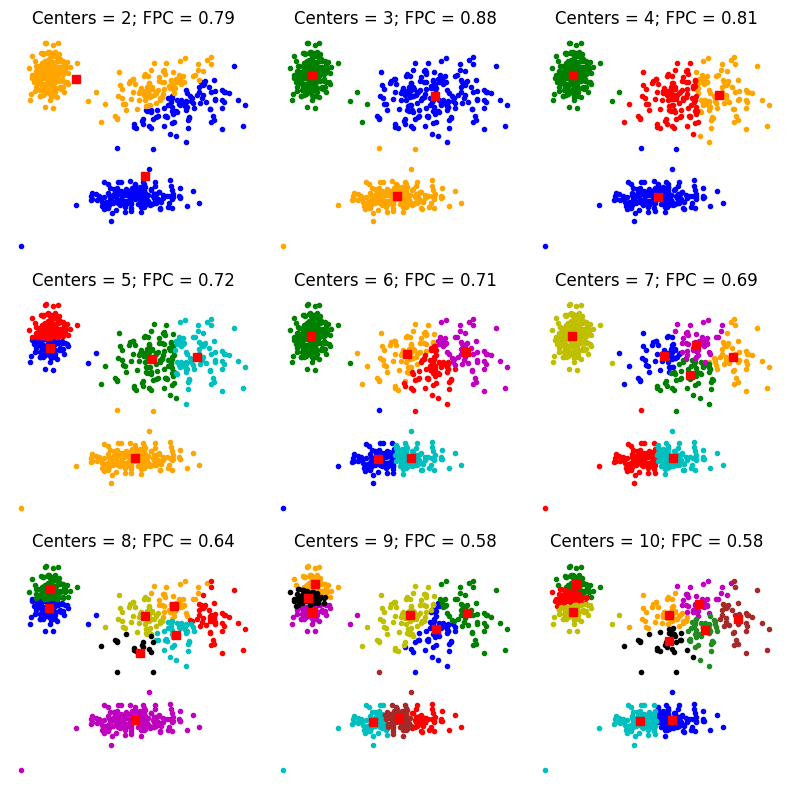

In [2]:
# try clustering test data several times, with between 2 and 9 clusters
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

Text(0, 0.5, 'Fuzzy partition coefficient')

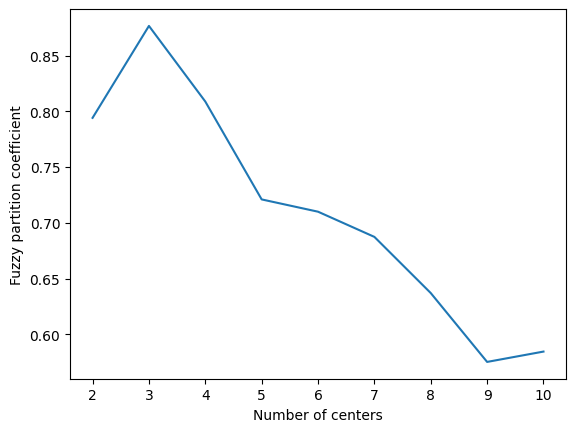

In [3]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

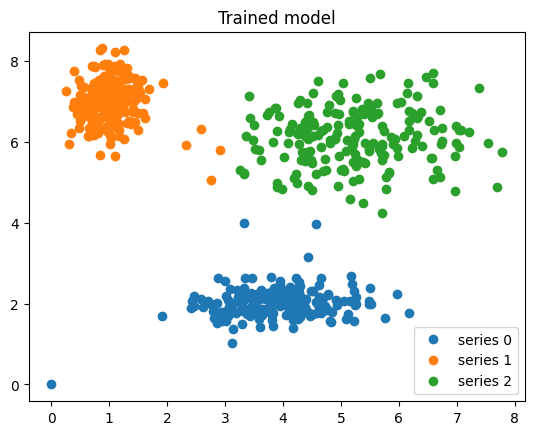

In [4]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

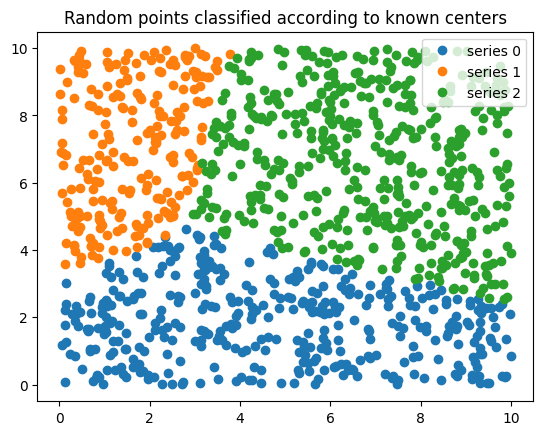

In [5]:
# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classified according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## Typical Fuzzy Control System
Many fuzzy control systems are tasked to keep a certain variable close to a specific value. For instance, the temperature for an industrial chemical process might need to be kept relatively constant. In order to do this, the system usually knows two things:

- The error, or deviation from the ideal value

- The way the error is changing. This is the mathematical first derivative; we’ll call it delta

From these two values we can construct a system which will act appropriately.

### Set up the Fuzzy Control System
We’ll use the new control system API for this problem. It would be far too complicated to model manually!

In [1]:
import numpy as np
import skfuzzy.control as ctrl

# Sparse universe makes calculations faster, without sacrifice accuracy.
# Only the critical points are included here; making it higher resolution is
# unnecessary.
universe = np.linspace(-2, 2, 5)    # [-2. -1. 0. 1. 2.]

# Create the three fuzzy variables - two inputs, one output
error = ctrl.Antecedent(universe, 'error')
delta = ctrl.Antecedent(universe, 'delta')
output = ctrl.Consequent(universe, 'output')

# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
delta.automf(names=names)
output.automf(names=names)

### Define complex rules
This system has a complicated, fully connected set of rules defined below.

In [2]:
rule0 = ctrl.Rule(antecedent=((error['nb'] & delta['nb']) |
                              (error['ns'] & delta['nb']) |
                              (error['nb'] & delta['ns'])),
                  consequent=output['nb'], label='rule nb')

rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
                              (error['nb'] & delta['ps']) |
                              (error['ns'] & delta['ns']) |
                              (error['ns'] & delta['ze']) |
                              (error['ze'] & delta['ns']) |
                              (error['ze'] & delta['nb']) |
                              (error['ps'] & delta['nb'])),
                  consequent=output['ns'], label='rule ns')

rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
                              (error['ns'] & delta['ps']) |
                              (error['ze'] & delta['ze']) |
                              (error['ps'] & delta['ns']) |
                              (error['pb'] & delta['nb'])),
                  consequent=output['ze'], label='rule ze')

rule3 = ctrl.Rule(antecedent=((error['ns'] & delta['pb']) |
                              (error['ze'] & delta['pb']) |
                              (error['ze'] & delta['ps']) |
                              (error['ps'] & delta['ps']) |
                              (error['ps'] & delta['ze']) |
                              (error['pb'] & delta['ze']) |
                              (error['pb'] & delta['ns'])),
                  consequent=output['ps'], label='rule ps')

rule4 = ctrl.Rule(antecedent=((error['ps'] & delta['pb']) |
                              (error['pb'] & delta['pb']) |
                              (error['pb'] & delta['ps'])),
                  consequent=output['pb'], label='rule pb')

Despite the lengthy ruleset, the new fuzzy control system framework will execute in milliseconds. Next we add these rules to a new `ControlSystem` and define a `ControlSystemSimulation` to run it.

In [3]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

# Later we intend to run this system with a 21*21 set of inputs, so we allow
# that many plus one unique runs before results are flushed.
# Subsequent runs would return in 1/8 the time!
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

### View the control space
With helpful use of Matplotlib and repeated simulations, we can observe what the entire control system surface looks like in three dimensions!

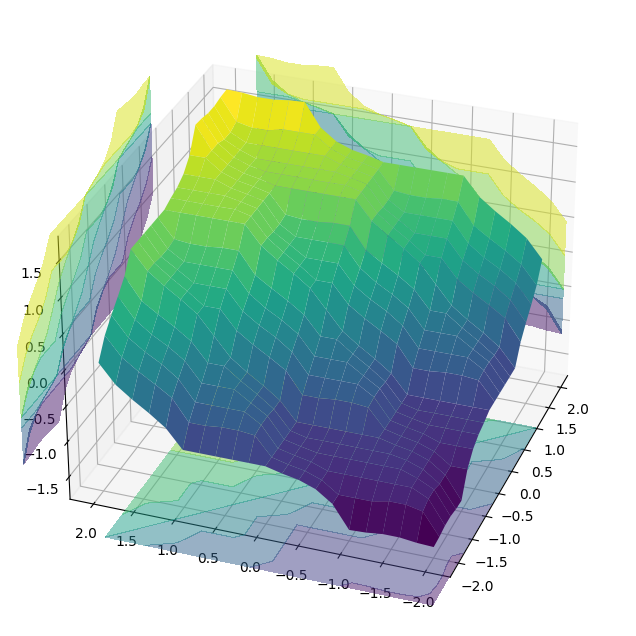

In [30]:
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        sim.input['error'] = x[i, j]
        sim.input['delta'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['output']

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt  # noqa: E402

# Required for 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401,E402

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)

## Defuzzification
Fuzzy logic calculations are excellent tools, but to use them the fuzzy result must be converted back into a single number. This is known as defuzzification.

There are several possible methods for defuzzification, exposed via `skfuzzy.defuzz`.

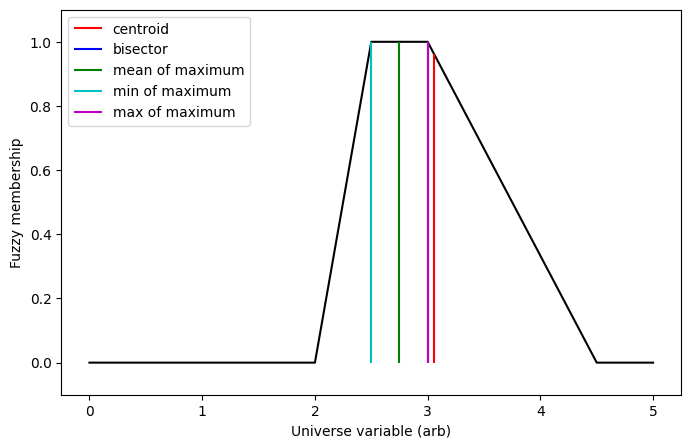

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz


# Generate trapezoidal membership function on range [0, 1]
x = np.arange(0, 5.05, 0.1)
mfx = fuzz.trapmf(x, [2, 2.5, 3, 4.5])

# Defuzzify this membership function five ways
defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
# plt.vlines(xvals[1], 0, ymax[1], label=labels[1], color=colors[1])
plt.ylabel('Fuzzy membership')
plt.xlabel('Universe variable (arb)')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()

## The Tipping Problem - The Hard Way
The ‘tipping problem’ is commonly used to illustrate the power of fuzzy logic principles to generate complex behavior from a compact, intuitive set of expert rules.

### Input variables
A number of variables play into the decision about how much to tip while dining. Consider two of them:

- quality : Quality of the food

- service : Quality of the service

### Output variable
The output variable is simply the tip amount, in percentage points:

- tip : Percent of bill to add as tip

For the purposes of discussion, let’s say we need ‘high’, ‘medium’, and ‘low’ membership functions for both input variables and our output variable. These are defined in `scikit-fuzzy` as follows

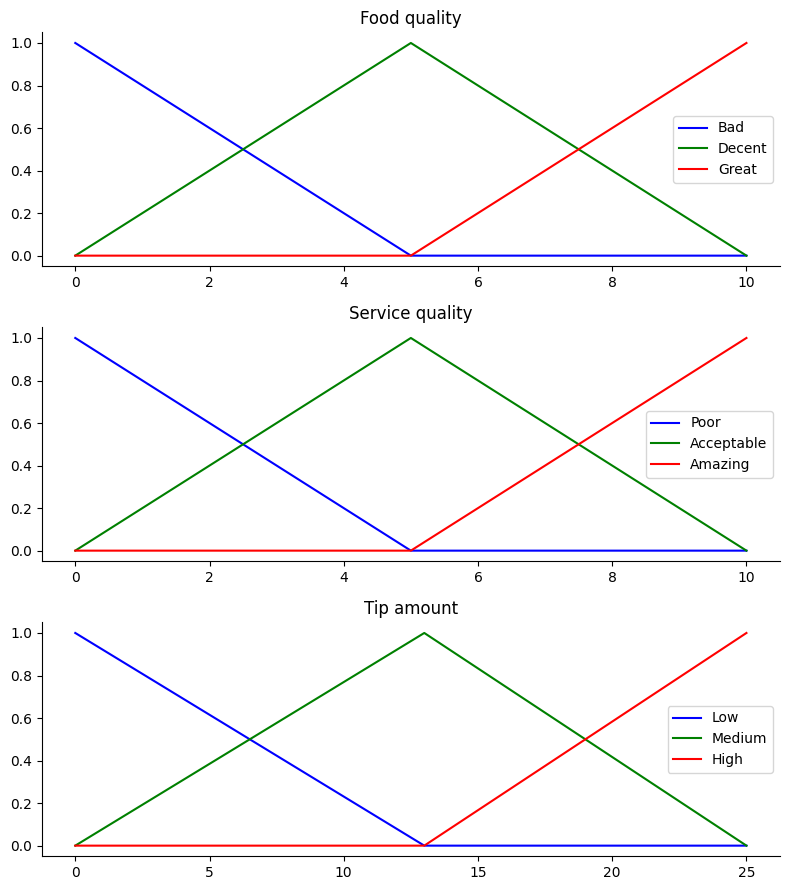

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_qual = np.arange(0, 11, 1)    # array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
x_serv = np.arange(0, 11, 1)
x_tip = np.arange(0, 26, 1)     # array([ 0, ..., 25])

# Generate fuzzy membership functions
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])     # array([1. , 0.8, 0.6, 0.4, 0.2, 0. , 0. , 0. , 0. , 0. , 0. ])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])   # array([0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. ])
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])     
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


### Fuzzy rules
Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

- If the food is bad OR the service is poor, then the tip will be low

- If the service is acceptable, then the tip will be medium

- If the food is great OR the service is amazing, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.

### Rule application
What would the tip be in the following circumstance:

- Food quality was 6.5

- Service was 9.8

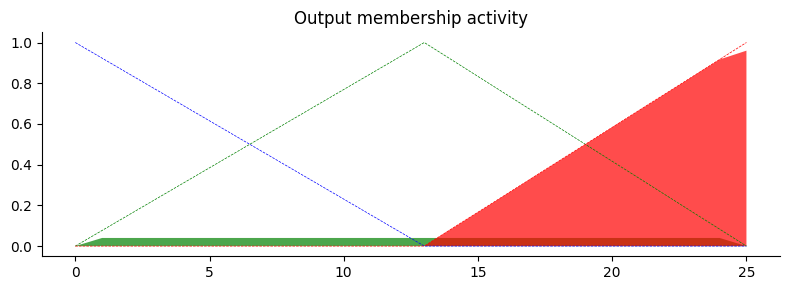

In [2]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

### Rule aggregation
With the activity of each output membership function known, all output membership functions must be combined. This is typically done using a maximum operator. This step is also known as aggregation.

### Defuzzification
Finally, to get a real world answer, we return to crisp logic from the world of fuzzy membership functions. For the purposes of this example the centroid method will be used.

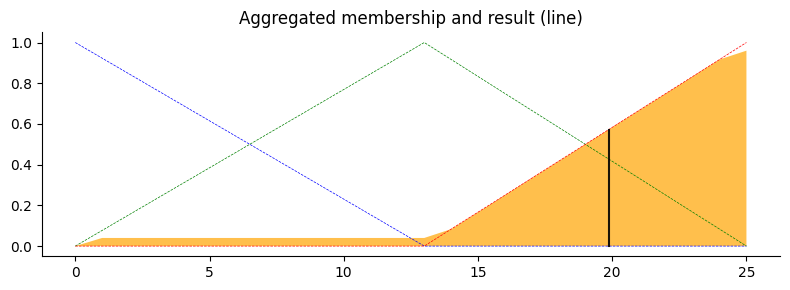

In [3]:
# Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

### Final thoughts
The power of fuzzy systems is allowing complicated, intuitive behavior based on a sparse system of rules with minimal overhead. Note our membership function universes were coarse, only defined at the integers, but `fuzz.interp_membership` allowed the effective resolution to increase on demand. This system can respond to arbitrarily small changes in inputs, and the processing burden is minimal.

## Fuzzy Control Systems: The Tipping Problem
Let’s create a fuzzy control system which models how you might choose to tip at a restaurant. When tipping, you consider the service and food quality, rated between 0 and 10. You use this to leave a tip of between 0 and 25%.

We would formulate this problem as:

### Antecedents (Inputs)
- service
    - Universe (ie, crisp value range): How good was the service of the wait staff, on a scale of 0 to 10?

    - Fuzzy set (ie, fuzzy value range): poor, acceptable, amazing

- food quality
    - Universe: How tasty was the food, on a scale of 0 to 10?

    - Fuzzy set: bad, decent, great

### Consequents (Outputs)
- tip
    - Universe: How much should we tip, on a scale of 0% to 25%

    - Fuzzy set: low, medium, high
  
### Rules
- IF the service was good or the food quality was good, THEN the tip will be high.

- IF the service was average, THEN the tip will be medium.

- IF the service was poor and the food quality was poor THEN the tip will be low.

### Usage
- If I tell this controller that I rated:
    - the service as 9.8, and

    - the quality as 6.5,

- it would recommend I leave:
    - a 20.2% tip.

### Creating the Tipping Controller Using the skfuzzy control API
We can use the skfuzzy control system API to model this. First, let’s define fuzzy variables

In [24]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

To help understand what the membership looks like, use the `view` methods.

These return the matplotlib Figure and Axis objects. They are persistent as written in Jupyter notebooks; other environments may require a plt.show() command after each .view().

d:\Anaconda\envs\mytorch\lib\site-packages\skfuzzy\control\term.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


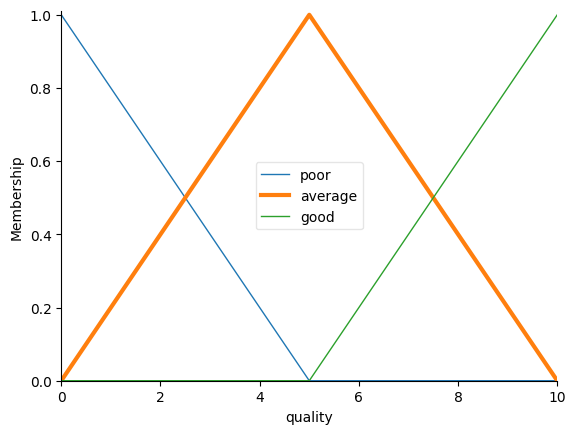

In [28]:
# You can see how these look with .view()
quality['average'].view()

d:\Anaconda\envs\mytorch\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


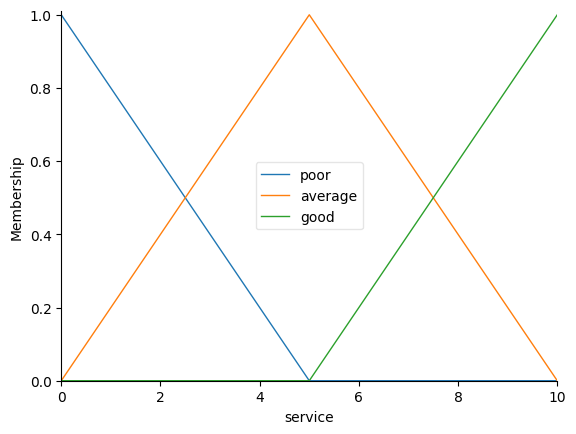

In [29]:
service.view()

d:\Anaconda\envs\mytorch\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


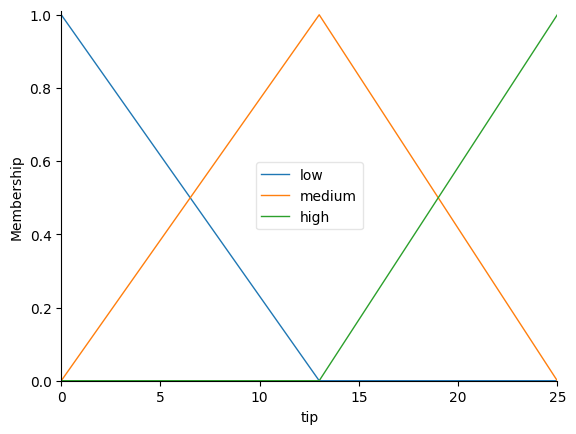

In [25]:
tip.view()

### Fuzzy rules
Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

1. If the food is poor OR the service is poor, then the tip will be low

1. If the service is average, then the tip will be medium

1. If the food is good OR the service is good, then the tip will be high.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

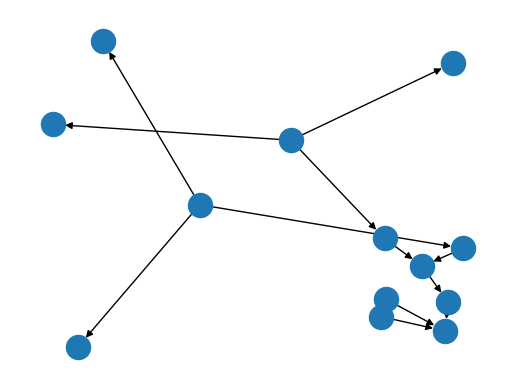

In [30]:
rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

rule1.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

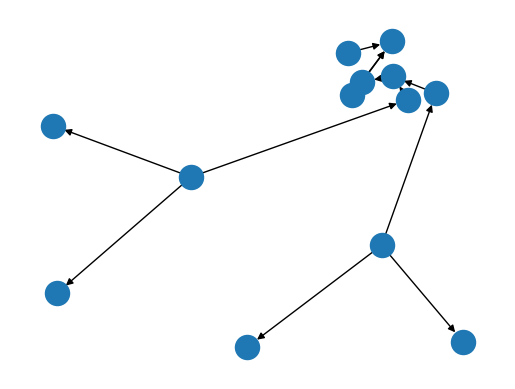

In [32]:
rule1.view()

### Control System Creation and Simulation
Now that we have our rules defined, we can simply create a control system via:

In [33]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

In order to simulate this control system, we will create a `ControlSystemSimulation`. Think of this object representing our controller applied to a specific set of circumstances. For tipping, this might be tipping Sharon at the local brew-pub. We would create another `ControlSystemSimulation` when we’re trying to apply our `tipping_ctrl` for Travis at the cafe because the inputs would be different.

In [34]:
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

We can now simulate our control system by simply specifying the inputs and calling the compute method. Suppose we rated the quality 6.5 out of 10 and the service 9.8 of 10.

In [35]:
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

Once computed, we can view the result as well as visualize it.

19.847607361963192


d:\Anaconda\envs\mytorch\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


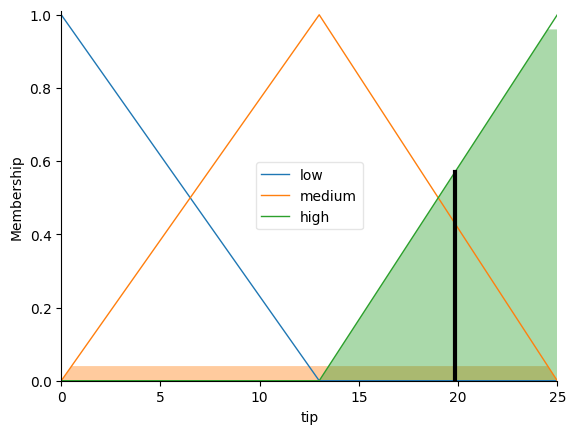

In [36]:
print(tipping.output['tip'])
tip.view(sim=tipping)

### Final thoughts
The power of fuzzy systems is allowing complicated, intuitive behavior based on a sparse system of rules with minimal overhead. Note our membership function universes were coarse, only defined at the integers, but `fuzz.interp_membership` allowed the effective resolution to increase on demand. This system can respond to arbitrarily small changes in inputs, and the processing burden is minimal.